In [89]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats
import pandas as pd
import seaborn as sns

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


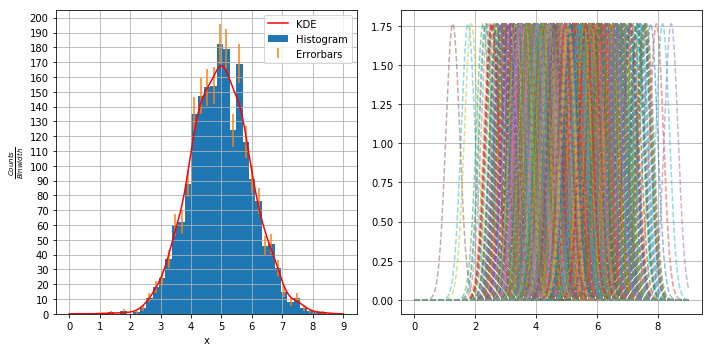

In [2]:
#setting the initial dataset
N = 2000
mean = 5
std = 1
x = np.random.normal(mean, std, N)


#calculating the number of bins employing Freedman-Diaconis rule
iqr = np.subtract(*np.percentile(x, [75, 25]))
h = 2 * iqr / (N**(1/3))
nbin = int((x.max() - x.min())/h)


#setting labels and ticks
fig, (ax, ga) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax.hist(x, bins = nbin, label = "Histogram")
ax.set_ylabel(r'$\frac{Counts}{Bin width}$')
ax.yaxis.label.set_size(15)
ax.set_xlabel('x')
his, edges =  np.histogram(x, bins = nbin)
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))


#setting the errorbars
halfway = [(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)]
ax.errorbar(halfway, his, his**(1/2), fmt = 'none', label = "Errorbars")


#creating gaussians (their moments)
std = 1.06*np.std(x)*(x.size**(-1/5))
gauss = np.array([[x[i], std] for i in range(len(x))])


#plotting the gaussians
x_axis = np.linspace(int(x.min()-4*std), int(x.max()+4*std), 1000)
for i  in range(len(x)):
    ga.plot(x_axis, sp.stats.norm.pdf(x_axis, gauss[i,0], gauss[i,1]), ls = '--', alpha = 0.5)


#summing the gaussians
total = np.array([np.sum(sp.stats.norm.pdf(x_axis[i], gauss[:,0], gauss[:,1])) for i in range(len(x_axis))])

#normalization
norm = sp.integrate.trapz(total, x_axis)
normhist = sp.integrate.trapz(his, halfway)

#  #  a  e  s  t  h  e  t  i  c  s  #  #

ax.plot(x_axis, total/norm*normhist, color = 'red', label = "KDE")
ax.grid()
ga.grid()
ax.legend()
fig.tight_layout()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

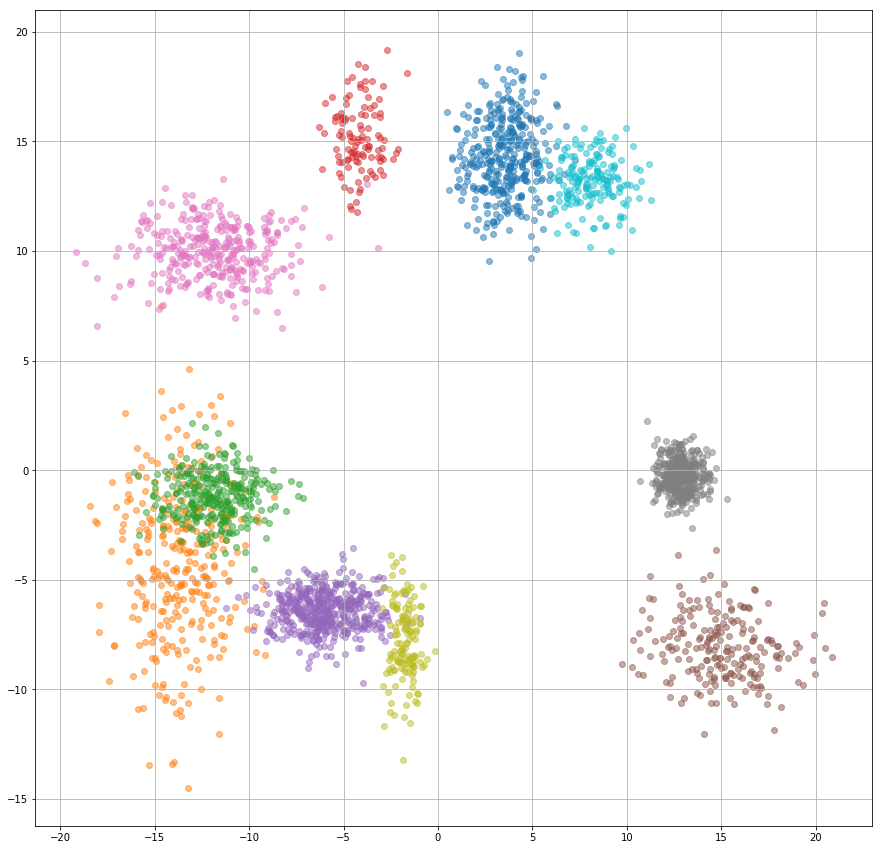

In [65]:
m = 15 #mean of the uniform distribution from which the means of the gaussians are drawn

lm = 0.5 #mean of the lognormal distribution from which the stds of the gaussians are drawn
sm = 0.5 #std of the lognormal distribution from which the stds of the gaussians are drawn

N = 10 #number of clusters

c_low = 100 #lower bound on number of samples per category
c_high = 500 #upper bound on number of samples per category




fig = plt.figure(figsize=(15,15))
axx = fig.add_subplot(1, 1, 1)

for i in range(N):
    
    size = np.random.randint(c_low, high = c_high) #size of each cluster
    
    mx = np.random.uniform(-m,m)
    sx = np.random.lognormal(lm,sm)

    my = np.random.uniform(-m,m)
    sy = np.random.lognormal(lm,sm)
    
    x = [np.random.normal(mx,sx) for j in range(size)]
    y = [np.random.normal(my,sy) for j in range(size)]
    
    axx.scatter(x,y, alpha = 0.5)
    

    
axx.grid()    
plt.show()

--2018-11-28 17:33:16--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [following]
--2018-11-28 17:33:17--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0040c52817192c31b70f4c2741.dl.dropboxusercontent.com/cd/0/inline/AWfmDY_WgMR8FL2yL8eqI_peeT_2CMq7VHTeXGf8jVBi_KI7eatWwlGyvYHMPZbnnYcixou8y7tw0qVugCfMACIk5ulBxxu2JA_OfDuwwPfxpK9XVkFO4OAco6ZQgeAMTJ1qoxyzt70qM7vWoe53AYYUmSJgMIe4FArokqXYxRwb54Ckv4w37o7EI5iuHzYhRxA/file [following]
--2018-11-28 17:33:17--  https://uc0040c52817192c31b70f4c2741.dl.dropboxusercontent.com/cd/

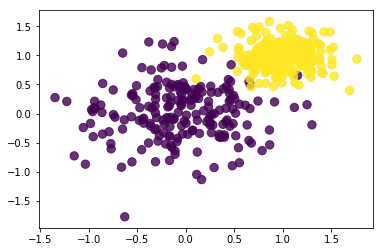

In [99]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')


3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should you the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

/opt/ubuntu-16.04/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


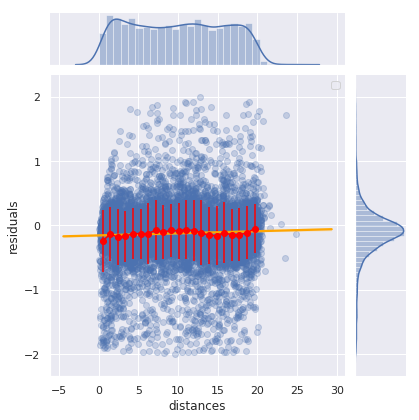

In [172]:
#filling 
dataraw = pd.DataFrame(np.load('residuals_261.npy').item())

#cleaning
data = dataraw[np.absolute(dataraw['residuals'])<2]
data

#linear regression
stuff = sp.stats.linregress(dataraw['distances'], dataraw['residuals'])
slope = lambda a, b: sp.stats.linregress(a, b)[0]
intercept = lambda a, b: sp.stats.linregress(a, b)[1]



#seaborn plot
sns.set()
pl = sns.jointplot(x = 'distances', y = 'residuals', data = data, kind = 'reg', scatter_kws={'alpha':0.25}, joint_kws={'line_kws':{'color':'orange'}})


#filling the array x


#calculating the number of bins employing Freedman-Diaconis rule
iqr = np.subtract(*np.percentile(data['distances'], [75, 25]))
h = 2 * iqr / (len(data['distances'])**(1/3))
nbin = int((data['distances'].max() - data['distances'].min())/h)

#getting the bin centers
his, edges =  np.histogram(data['distances'], bins = nbin)
x = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])


#filling the array y
y = data.groupby(pd.cut(data['distances'], bins = nbin)).mean().unstack('distances')['residuals'].fillna(value=0)



#filling the array yerr
yerr = data.groupby(pd.cut(data['distances'], bins = nbin)).std().unstack('distances')['residuals'].fillna(value=0)


#limiting the arrays to approx 20 in distances
x = x[x - 20 < 0]
y = y[:len(x)]
yerr = yerr[:len(x)]


#plotting profile
plt.errorbar(x,y,yerr, color = 'red', marker = 'o')
pl.ax_joint.legend()